# Fake News Classification
We are given a set of news articles and their titles. They are indicated as either fake or not with a binary classifier.

The nature of the problem suggests that there's some way to tell these types of articles apart, and we need to take it on good faith that the classification is correct, as determining real-world "truth" value would be difficult here.

The hypthesis to this challenge is that there is some latent factor or some indicator for "fake news" based on the language used within the article and title itself.

Using nlp text processing techniques and a selection of unsupervised learning models, we will attempt to classify these articles as fake or not.

The feature engineering will be important here, so we will utilize a few methodologies to massage the data into the correct shape, such as:
- count vectorization
- tf-idf vectorization

In order to predict the labels, we will need to utilize ML models to accomplish this task. The models to be employed include:

- matrix factorization
- jaccard similarity
- cosine similarity

And finally, to aid in visualization, I hope to use the **T-SNE** algorithm to visualize clusters in a scatter chart. T-SNE is useful for reducing high dimensional data to a space that can be visualized more easily.

The data was lifted from the kaggle "Fake News Classification" project, <a href="https://www.kaggle.com/datasets/aadyasingh55/fake-news-classification/data">found at this link</a>

In [86]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
import tqdm # process bar for loops
import matplotlib.pyplot as plt # for plotting & visualization
import nltk # for cleaning up the text data

In [87]:
import os
list(os.walk('data'))

[('data', [], ['evaluation.csv', 'test (1).csv', 'train (2).csv'])]

In [88]:
test = pd.read_csv(r"data\test (1).csv", delimiter=";")
train = pd.read_csv(r"data\train (2).csv", delimiter=";")
evaluation = pd.read_csv(r"data\evaluation.csv", delimiter=";")

In [89]:
train.head()

,Unnamed: 0,title,text,label
0,0,Palestinians switch off Christmas lights in Be...,"RAMALLAH, West Bank (Reuters) - Palestinians s...",1
1,1,China says Trump call with Taiwan president wo...,BEIJING (Reuters) - U.S. President-elect Donal...,1
2,2,FAIL! The Trump Organization’s Credit Score W...,While the controversy over Trump s personal ta...,0
3,3,Zimbabwe military chief's China trip was norma...,BEIJING (Reuters) - A trip to Beijing last wee...,1
4,4,THE MOST UNCOURAGEOUS PRESIDENT EVER Receives ...,There has never been a more UNCOURAGEOUS perso...,0


The label of 1 appears to be real, and 0 appears to be fake.

# Exploratory Data Analysis
I primarily want to see which words are highly correlated between article types, and then expand that out into bigrams and trigrams as well.

In [90]:
from collections import Counter
import re
from nltk.tokenize import word_tokenize

# per article count individual tokens
eda_df = train.copy()

stop_words = set(nltk.corpus.stopwords.words('english'))
english_words = set(nltk.corpus.words.words())
punctuation_re = re.compile(r'[^\w\s]')

# Function to clean and tokenize text
def process_data(df):
    # Remove punctuation
    df['cleaned_text'] = df['text'].str.replace(punctuation_re, '', regex=True)
    # Tokenize
    df['split_tokens'] = df['cleaned_text'].apply(word_tokenize)
    # Lowercase all tokens and filter out non-English words and stopwords
    def filter_tokens(tokens):
        return [word.lower() for word in tokens if word.lower() not in stop_words]

    df['filtered_tokens'] = df['split_tokens'].apply(filter_tokens)
    # Count tokens
    df['counted_tokens'] = df['filtered_tokens'].apply(Counter)
    # reconstitute the text
    df['text'] = df['filtered_tokens'].apply(lambda x: ' '.join(x))
    return df

eda_df = process_data(eda_df)
eda_df.head(2)

,Unnamed: 0,title,text,label,cleaned_text,split_tokens,filtered_tokens,counted_tokens
0,0,Palestinians switch off Christmas lights in Be...,ramallah west bank reuters palestinians switch...,1,RAMALLAH West Bank Reuters Palestinians switc...,"[RAMALLAH, West, Bank, Reuters, Palestinians, ...","[ramallah, west, bank, reuters, palestinians, ...","{'ramallah': 2, 'west': 1, 'bank': 1, 'reuters..."
1,1,China says Trump call with Taiwan president wo...,beijing reuters us presidentelect donald trump...,1,BEIJING Reuters US Presidentelect Donald Trum...,"[BEIJING, Reuters, US, Presidentelect, Donald,...","[beijing, reuters, us, presidentelect, donald,...","{'beijing': 1, 'reuters': 1, 'us': 1, 'preside..."


In [91]:
# prepare receiver dictionary to store word counts
wordcount_dict = dict()
wordcount_dict[1] = dict()
wordcount_dict[0] = dict()
# iterate over each row of the dataframe and add the token counts to the receiver dictionary
for row in eda_df.iterrows():
    label = row[1]['label']
    for token in row[1]['counted_tokens'].items():
        if token[0] in wordcount_dict[label]:
            wordcount_dict[label][token[0]] += token[1]
        else:
            wordcount_dict[label][token[0]] = token[1]

In [92]:
count_by_class = (
    pd
    .DataFrame(wordcount_dict)
    .sort_values(
        by=1, 
        ascending=False
    )
)
count_by_class

,1,0
said,59987.0,14477.0
trump,26716.0,38867.0
us,25423.0,9521.0
would,19515.0,11532.0
reuters,17045.0,186.0
...,...,...
8009641800,NaN,1.0
tweetheart,NaN,1.0
tweetheart2017,NaN,1.0
divethis,NaN,1.0


### Adding entropy as a metric
I am interested to see how the words are aligned by fake/real article based on their entropy. This metric should help us to quantify their ability to determine the purity of the set that they are in.

In [93]:
counted_words = (
    count_by_class
    .reset_index()
    .rename(
        columns={'index':'word'}
    )
)
# filter out stopwords
real_words_only = counted_words[counted_words['word'].isin(nltk.corpus.words.words())]
metrics_added = counted_words.copy()
# add metrics to do some more exploration
metrics_added['prob_fake'] = metrics_added[0] / (metrics_added[1] + metrics_added[0])
metrics_added['prob_real'] = metrics_added[1] / (metrics_added[1] + metrics_added[0])
# calculate entropy to show the ability for one word to predict the class
metrics_added['entropy'] = -1 * (
    metrics_added['prob_fake'] * np.log2(metrics_added['prob_fake']) +
    metrics_added['prob_real'] * np.log2(metrics_added['prob_real'])
)
# rename columns
metrics_added.rename(columns={0:'fake_count', 1:'real_count'}, inplace=True)
metrics_added['total_count'] = metrics_added['fake_count'] + metrics_added['real_count']


In [94]:
likely_fake_token_indicators = metrics_added[(metrics_added['prob_fake'] < metrics_added['prob_real']) & 
              (metrics_added['total_count'] > 100)].sort_values(by='entropy').head(10)
likely_fake_token_indicators

,word,real_count,fake_count,prob_fake,prob_real,entropy,total_count
412,rohingya,1262.0,1.0,0.000792,0.999208,0.009299,1263.0
247,myanmar,1734.0,2.0,0.001152,0.998848,0.012907,1736.0
1246,hariri,487.0,1.0,0.002049,0.997951,0.021254,488.0
1579,spd,380.0,1.0,0.002625,0.997375,0.026285,381.0
1058,catalonia,569.0,2.0,0.003503,0.996497,0.033617,571.0
2600,hun,209.0,1.0,0.004762,0.995238,0.043588,210.0
2703,alzor,198.0,1.0,0.005025,0.994975,0.045606,199.0
1533,ite,391.0,2.0,0.005089,0.994911,0.046094,393.0
2786,corrects,192.0,1.0,0.005181,0.994819,0.046795,193.0
2811,temer,190.0,1.0,0.005236,0.994764,0.047206,191.0


In [95]:
likely_real_token_indicators = metrics_added[(metrics_added['prob_fake'] > metrics_added['prob_real']) & 
              (metrics_added['total_count'] > 100)].sort_values(by='entropy').head(10)
likely_real_token_indicators

,word,real_count,fake_count,prob_fake,prob_real,entropy,total_count
36005,reilly,2.0,412.0,0.995169,0.004831,0.044119,414.0
58320,boiler,1.0,201.0,0.995050,0.004950,0.045036,202.0
29622,screenshot,3.0,587.0,0.994915,0.005085,0.046061,590.0
71057,somodevillagetty,1.0,179.0,0.994444,0.005556,0.049614,180.0
49885,fck,1.0,155.0,0.993590,0.006410,0.055920,156.0
47866,wonggetty,1.0,153.0,0.993506,0.006494,0.056525,154.0
53147,lemon,1.0,120.0,0.991736,0.008264,0.069054,121.0
46997,sht,1.0,119.0,0.991667,0.008333,0.069530,120.0
51867,fcking,1.0,115.0,0.991379,0.008621,0.071504,116.0
36500,infowars,2.0,225.0,0.991189,0.008811,0.072801,227.0


# EDA Result
The interesting thing revealed by adding the entropy metric shows that "real" articles have a large number of place names like Barcelona, Zimbabwe, or Bangkok. The supposed "fake" articles tend to have no discernible pattern for low-entropy indicators. Some of the words in the "fake" articles don't even appear to be real words, like er, das, and tapper. Very interesting results.

# Count Vectorized prediction with NMF
As a baseline, we will use count-vectorized tokens to feed into the NMF unsupervised classifier to see how well the data is naturally segregated.

# Count vectorized NMF Experiment

In [ ]:
# stage model
nmf = NMF(n_components=2, random_state=1, init='nndsvd')
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
cleaned_data = process_data(train.copy())
vectorized_data = count_vectorizer.fit_transform(cleaned_data['text'])
nmf_data = nmf.fit_transform(vectorized_data)
component_labels = nmf_data.argmax(axis=1)
confusion_matrix(cleaned_data['label'], component_labels)

In [ ]:
print(classification_report(cleaned_data['label'], component_labels))

# Count Vectorized Articles with NMF - Result
As predicted, the count vectorizer performed extremely poorly, mapping almost everything to the 0 (Fake) category, and achieving an accuracy rate of 32%, less accurate than a coin toss.

That's fine! We can only improve from here!

With this as our baseline, I will begin working iteratively on better approaches.

# TF-IDF Vectorized Articles with NMF
Using a more sophisticated vectorization procedure may yield better results. Per the EDA step above, we were able to determine that the most common terms have significant overlap between the fake and real articles. TF-IDF will hopefully resolve that issue.

In [103]:
nmf = NMF(n_components=2, random_state=1, init='nndsvd')
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

In [104]:
vectorized_data = tfidf_vectorizer.fit_transform(cleaned_data['text'])
nmf_data = nmf.fit_transform(vectorized_data)
component_labels = nmf_data.argmax(axis=1)
confusion_matrix(cleaned_data['label'], component_labels)

array([[9254, 1853],
       [3641, 9605]], dtype=int64)

In [105]:
print(classification_report(cleaned_data['label'], component_labels))

              precision    recall  f1-score   support

           0       0.72      0.83      0.77     11107
           1       0.84      0.73      0.78     13246

    accuracy                           0.77     24353
   macro avg       0.78      0.78      0.77     24353
weighted avg       0.78      0.77      0.77     24353



Seems a bit low, what if we just work with uncleaned data?

In [124]:
nmf = NMF(n_components=2, random_state=1, init='nndsvda', solver='mu')
vectorized_data = tfidf_vectorizer.fit_transform(cleaned_data['text'])
nmf_data = nmf.fit_transform(vectorized_data)
component_labels = nmf_data.argmax(axis=1)

confusion_matrix(cleaned_data['label'], component_labels)

array([[10588,   519],
       [ 6241,  7005]], dtype=int64)

In [125]:
print(accuracy_score(cleaned_data['label'], component_labels))

0.7224161294296391


In [109]:
print(classification_report(train['label'], component_labels))

              precision    recall  f1-score   support

           0       0.62      0.95      0.75     11107
           1       0.93      0.50      0.65     13246

    accuracy                           0.71     24353
   macro avg       0.77      0.73      0.70     24353
weighted avg       0.78      0.71      0.70     24353



No improvement when just using uncleaned data. Scores actually got worse.

# TF-IDF Vectorized Articles with NMF - Result
We still have a relatively low accuracy score of 71%. Perhaps if we add more resolution to the data by vectorizing 2-grams rather than single tokens, we may uncover better components.

Note: An n-Gram is n words in sequence. If the string is "It is sunny today" then 2-grams would be (it, is), (is, sunny), (sunny, today), rather than single tokens of each word.

In [165]:
# n-gram vectorization results, 1-5
nmf_accuracy_results = []
conf_matrices = []
for i in range(2, 5):
    print(f"Processing ngram range: {i}")
    nmf = NMF(n_components=2, random_state=1, init="nndsvd")
    tfidf_vectorizer = TfidfVectorizer(
        max_df=0.95, min_df=2, stop_words="english", ngram_range=(1, i)
    )
    nmf_data = nmf.fit_transform(tfidf_vectorizer.fit_transform(cleaned_data["text"]))
    component_labels = nmf_data.argmax(axis=1)
    nmf_accuracy_results.append(accuracy_score(cleaned_data["label"], component_labels))
    conf_matrices.append(confusion_matrix(cleaned_data["label"], component_labels))
    print(f"For ngram range {i}, accuracy is {nmf_accuracy_results[-1]}")

Processing ngram range: 2
For ngram range 2, accuracy is 0.7614667597421262
Processing ngram range: 3
For ngram range 3, accuracy is 0.78388699544204
Processing ngram range: 4
For ngram range 4, accuracy is 0.7926333511271711


In [166]:
# insert the 1gram accuracy from earlier
nmf_accuracy_results.insert(0, 0.7224161294296391)

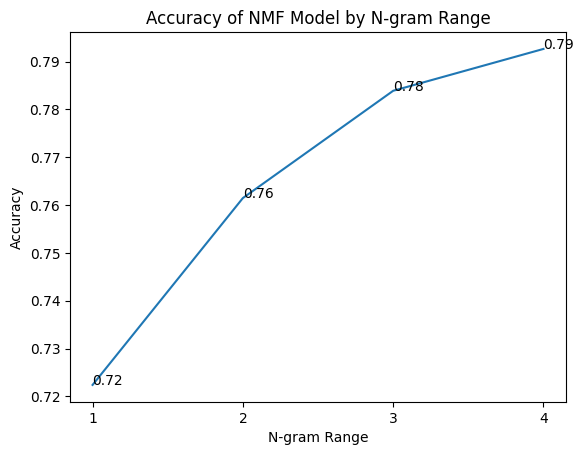

In [168]:
#plot accuracy results
plt.plot(range(1, 5), nmf_accuracy_results)
plt.xticks(range(1, 5))
# insert overlay text
for i, txt in enumerate(nmf_accuracy_results):
    plt.annotate(f"{txt:.2f}", (range(1, 5)[i], nmf_accuracy_results[i]))
plt.xlabel("N-gram Range")
plt.ylabel("Accuracy")
plt.title("Accuracy of NMF Model by N-gram Range")
plt.show()

# N-Gram with NMF Result
Not as good as I had hoped, but better. We seem to hit a wall with what we can accomplish with this method, even when we clean the data and remove stopwords. After 5grams, the calculation time begins to explode and diminishing returns comes into play. Another model is likely necessary to have any appreciable gain in accuracy worth testing with the test dataset.

# LDA with Vectorized tokens
As a final attempt, I will try to use the Latent Dirichlet model to build an unsupervised model which can pick out the relevant datapoints to our analysis.

In [172]:
lda_accuracy_results = list()
for i in range(1, 5):
    print(f"Processing iteration {i}")
    lda = LatentDirichletAllocation(n_components=2, random_state=1)
    tfidf_vectorizer = TfidfVectorizer(
        max_df=0.95, min_df=2, stop_words="english", ngram_range=(1, i)
    )

    vectorized_data = tfidf_vectorizer.fit_transform(cleaned_data["text"])
    lda_data = lda.fit_transform(vectorized_data)
    component_labels = lda_data.argmax(axis=1)
    lda_accuracy_results.append(accuracy_score(cleaned_data["label"], component_labels))
    print(f"For iteration {i}, accuracy is {lda_accuracy_results[-1]}")

Processing iteration 1
For iteration 1, accuracy is 0.8225680614298033
Processing iteration 2
For iteration 2, accuracy is 0.4536607399499035
Processing iteration 3
For iteration 3, accuracy is 0.5478996427544861
Processing iteration 4
For iteration 4, accuracy is 0.5487619595121751


Text(0.5, 1.0, 'Accuracy of LDA vs NMF Model by Iteration')

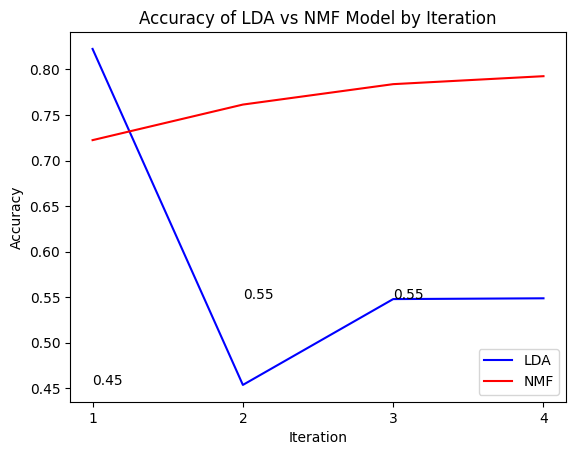

In [177]:
# plot next to NMF results to show improvement
plt.plot(range(1, 5), lda_accuracy_results, color='blue')
plt.plot(range(1, 5), nmf_accuracy_results, color='red')
plt.xticks(range(1, 5))
# legend
plt.legend(["LDA", "NMF"])
for i, txt in enumerate(lda_accuracy_results):
    plt.annotate(f"{txt:.2f}", (range(5)[i], lda_accuracy_results[i]))
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy of LDA vs NMF Model by Iteration")

# What happened!?
LDA did not perform at all how I expected it to. The performance started off very good, but became very bad as the TF IDF started adding n-grams to the dataset.

Researching the usage of LDA, I realize I was using it incorrectly and perhaps the CountVectorizer could shine here?

In [178]:
# use count vec with lda
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
lda = LatentDirichletAllocation(n_components=2, random_state=1)

vectorized_data = cv.fit_transform(cleaned_data['text'])
lda_data = lda.fit_transform(vectorized_data)
component_labels = lda_data.argmax(axis=1)

confusion_matrix(cleaned_data['label'], component_labels)

array([[10145,   962],
       [ 3186, 10060]], dtype=int64)

In [183]:
lda_cv_score = accuracy_score(cleaned_data['label'], component_labels)

Text(0.5, 1.0, 'Accuracy of LDA vs NMF Model by Iteration')

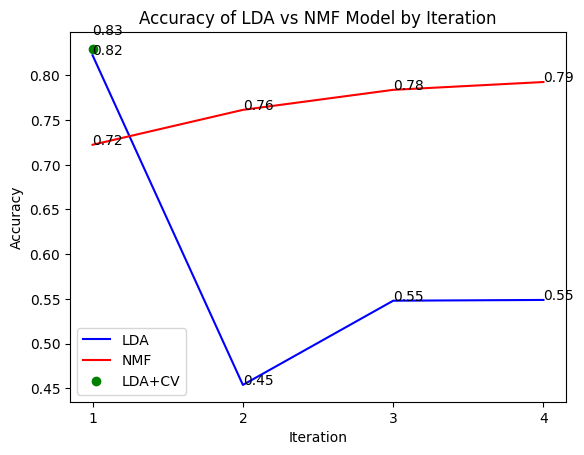

In [204]:
# plot next to NMF results to show improvement
plt.plot(range(1, 5), lda_accuracy_results, color='blue')
for i, txt in enumerate(lda_accuracy_results):
    plt.annotate(f"{txt:.2f}", (range(1,5)[i], lda_accuracy_results[i]))
plt.plot(range(1, 5), nmf_accuracy_results, color='red')
for i, txt in enumerate(nmf_accuracy_results):
    plt.annotate(f"{txt:.2f}", (range(1,5)[i], nmf_accuracy_results[i]))
plt.plot(1, lda_cv_score, 'go')
# add arrow and words pointing this out
plt.annotate(
        f"{lda_cv_score:.2f}", 
        (1, lda_cv_score), 
        textcoords="offset points", 
        xytext=(0,10), 
        ha='left'
    )
plt.xticks(range(1, 5))
plt.legend(["LDA", "NMF", 'LDA+CV'])
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy of LDA vs NMF Model by Iteration")

# Final Result
As we can see, the LDA with count vectorized data performed the best, as it expects count-vectorized data, and not the type of manipulated data that TF-IDF provides.

This result is surprising, and helped me learn more about which data transformation types help complement which models.